In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
import pysindy as ps

"In the year 1979, two theoretical physicists Mikhail Rabinovich and Anatoly Fabrikant, invented a new type of chaotic system, named Rabinovich-Fabrikant. it is  continuous in time domain and real in space domain, and it has three space dimensions and the other familiar chaotic systems contains only second-order nonlinearities (such as the Lorenz system), but the Rabinovich-Fabrikant chaotic attractor system with third-order nonlinearities presents some unusual dynamics, namely some complex dynamics that were rarely or never seen from other systems in the past, This system have shapes of waveforms like virtual “saddles” and even like “double vortex tornado” based on the varying parameters in the Rabinovich-Fabrikant equations". - Rabinovich-Fabrikant Chaotic System and its application to Secure Communication, Ravichandran 2021.<br><br>
The Rabinovich-Fabrikant equations are given by
$$\dot x = y(z - 1 + x^2) + \gamma x$$
$$\dot y = x(3z + 1 - x^2) + \gamma y$$
$$\dot z = -2z(\alpha + yx)$$
Where $\alpha$ and $\gamma$ are constants. The dynamics depend sensibly on $\alpha$ more than the dependence on $\gamma$, and the choice of these parameters along with the initial conditions determines wether the system is chaotic or not.<br>

According to Wikipidea, the system is found to exhibit chaotic behavior for the following values of the parameters and initial conditions:  $$\alpha = 1.1, \gamma = 0.87, x(0) = 1, y(0) = 0, z(0) = 0.5$$
And, according to the paper "Rabinovich-Fabrikant Chaotic System and its application to Secure Communication", the system is found to behave in a stable way for the following parameters:
$$\alpha = 0.1, \gamma = 0.077$$
The stable regime of this system showed non-linearity properties which paved the way to secure communication. <br>
Note: the stable regime is called "stable" because the solutions quickly converge to periodic oscillations.

I will solve this system in both the stable and chaotic regimes using odeint function, generating time series. Then, I will use these time series in a linear regression problem to recover the equations and compare the plotted solutions.

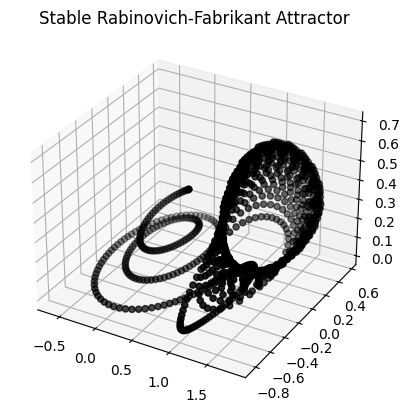

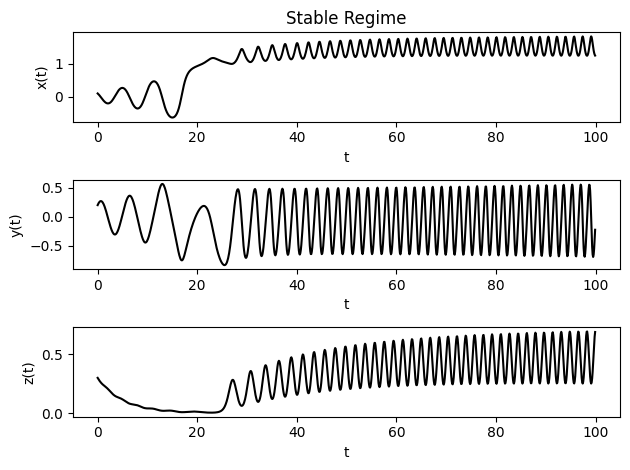

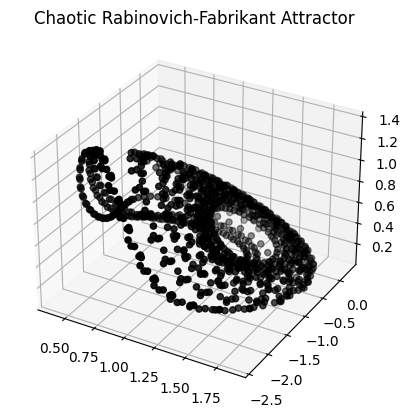

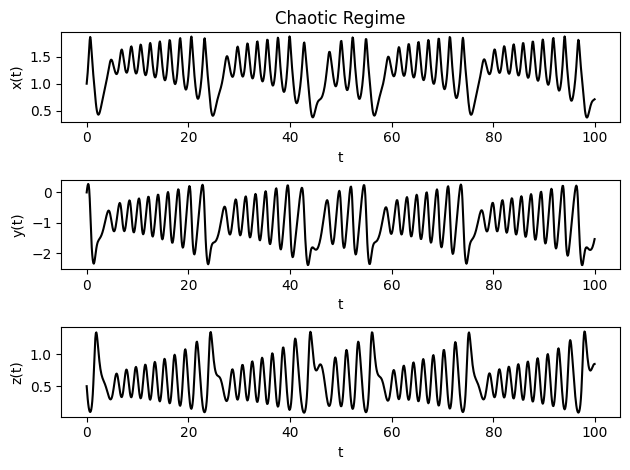

In [2]:
def Rabinovich_Fabrikant(X, t, alpha, gamma):
    x, y, z = X
    dx = y*z - y + x**2*y + gamma*x 
    dy = 3*x*z + x - x**3 + gamma*y
    dz = -2*alpha*z - 2*z*x*y
    return dx, dy, dz
t = np.arange(0, 100, 0.1)


# Stable Regime:
X01 = [0.1, 0.2, 0.3]
sol1 = odeint(Rabinovich_Fabrikant, X01, t, args = (0.1, 0.077))
x1,y1,z1 = sol1.T

figure = plt.figure()
ax = figure.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, color = 'k')
plt.title("Stable Rabinovich-Fabrikant Attractor")
plt.show()
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(t, x1, color = 'k')
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.set_title("Stable Regime")
ax2 = fig.add_subplot(312)
ax2.plot(t, y1, color = 'k')
ax2.set_xlabel('t')
ax2.set_ylabel('y(t)')
ax3 = fig.add_subplot(313)
ax3.plot(t, z1, color = 'k')
ax3.set_xlabel('t')
ax3.set_ylabel('z(t)')
plt.tight_layout()
plt.show()


# Chaotic Regime:
X02 = [1, 0, 0.5]
t = np.arange(0, 100, 0.1)
sol2 = odeint(Rabinovich_Fabrikant, X02, t, args = (1.1, 0.87))
x2,y2,z2 = sol2.T

figure_ = plt.figure()
ax_ = figure_.add_subplot(111, projection='3d')
ax_.scatter(x2, y2, z2, color = 'k')
plt.title("Chaotic Rabinovich-Fabrikant Attractor")
plt.show()
fig_ = plt.figure()
ax1_ = fig_.add_subplot(311)
ax1_.plot(t, x2, color = 'k')
ax1_.set_xlabel('t')
ax1_.set_ylabel('x(t)')
ax1_.set_title("Chaotic Regime")
ax2_ = fig_.add_subplot(312)
ax2_.plot(t, y2, color = 'k')
ax2_.set_xlabel('t')
ax2_.set_ylabel('y(t)')
ax3_ = fig_.add_subplot(313)
ax3_.plot(t, z2, color = 'k')
ax3_.set_xlabel('t')
ax3_.set_ylabel('z(t)')
plt.tight_layout()
plt.show()

Having generated 3 time series of data (x, y, z) for both the stable and chaotic regimes, I will now assume a 3rd order polynomial form in the data for the 3 differential equations. Introducing the feature vector:
$$\phi(x,y,z) = [1,x, y, z, x^2, y^2, z^2, xy, xz, yz, x^3, y^3, z^3, x^2y, x^2z, y^2x, y^2z, z^2x, z^2y, xyz]$$
And the output would be the discrete derivatives of the 3 time series (using numpy gradient function).<br>
Since the feature vector contains 20 features, the coefficient matrix would contain 20 coefficients for each equation, giving us 60 coefficients in total. We would need our coefficient matrix to be as sparce as possible while still returning reasonable values, so we will need to use Lasso regression with a very small alpha value (as we learned in problem 2).

In [7]:
# Stable Regime Lasso Regression:
phi1 = np.array([np.ones(len(x1)), x1, y1, z1, x1**2, y1**2, z1**2, x1*y1, x1*z1, y1*z1, x1**3, y1**3, z1**3, x1**2*y1, x1**2*z1, y1**2*x1, y1**2*z1, z1**2*x1, z1**2*y1, x1*y1*z1]).T

dx1 = np.gradient(x1,t)
dy1 = np.gradient(y1,t)
dz1 = np.gradient(z1,t)

dX1 = np.array([dx1, dy1, dz1]).T
reg1 = Lasso(alpha = 1e-5)
fit1 = reg1.fit(phi1, dX1)
coef1 = reg1.coef_
score1 = reg1.score(phi1, dX1)

# Chaotic Regime Lasso Regression:
phi2 = np.array([np.ones(len(x2)), x2, y2, z2, x2**2, y2**2, z2**2, x2*y2, x2*z2, y2*z2, x2**3, y2**3, z2**3, x2**2*y2, x2**2*z2, y2**2*x2, y2**2*z2, z2**2*x2, z2**2*y2, x2*y2*z2]).T

dx2 = np.gradient(x2,t)
dy2 = np.gradient(y2,t)
dz2 = np.gradient(z2,t)

dX2 = np.array([dx2, dy2, dz2]).T
reg2 = Lasso(alpha = 1e-4)
fit2 = reg2.fit(phi2, dX2)
coef2 = reg2.coef_
score2 = reg1.score(phi2, dX2)

print("Score for stable regime:", score1, "\nScore for chaotic regime:", score2)

Score for stable regime: 0.9998541487812082 
Score for chaotic regime: -0.8908631569518958


The score for the stable regime is $\approx$ 0.999, very close to 1.0, indicating that the fit is valid for the given data. However, the score for the chaotic regime is negative! being very far from 1 indicates a fit that diverges from the given data, which is something we expect to see in extremly chaotic systems.

Having found the coefficients values in the 2 regimes, we can now construct a new set of equations and solve them using odenint. I will then plot the solutions of the reconstructed equations and compare them to the solutions of the original equations in both regimes.

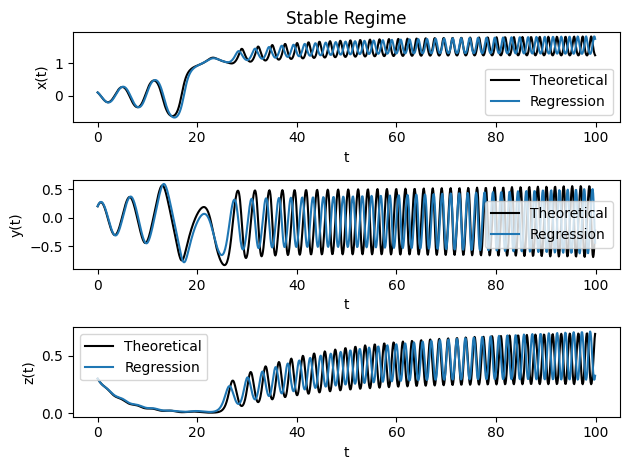

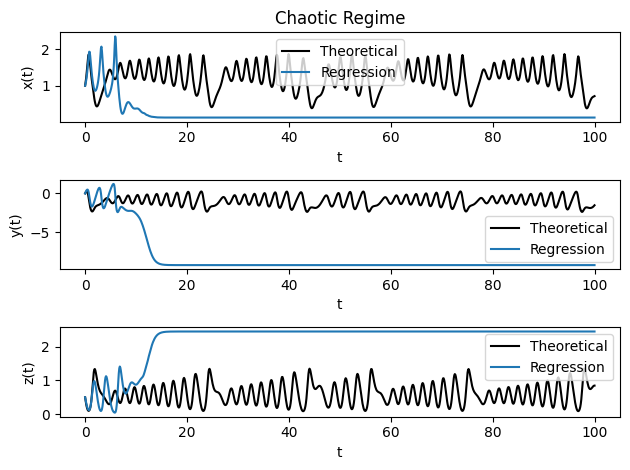

In [4]:
def RF_reg(X, t, coef):
    x, y, z = X
    library = [1, x, y, z, x**2, y**2, z**2, x*y, x*z, y*z, x**3, y**3, z**3, x**2*y, x**2*z, y**2*x, y**2*z, z**2*x, z**2*y, x*y*z]
    dX_dt = []
    for i in range(3):
        eqn = 0
        for j in range(coef.shape[1]):
            if coef[i, j] != 0:
                eqn += coef[i, j] * library[j]
        dX_dt.append(eqn)
    return dX_dt


# Stable:
D01 = [0.1, 0.2, 0.3]
solution_r1 = odeint(RF_reg, D01, t, args=(coef1,))
x_r1, y_r1, z_r1 = solution_r1.T

fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(t, x1, label = ('Theoretical'), color = 'k')
ax1.plot(t, x_r1, label=("Regression"))
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.set_title("Stable Regime")
ax1.legend()
ax2 = fig.add_subplot(312)
ax2.plot(t, y1, label = ('Theoretical'), color = 'k')
ax2.plot(t, y_r1, label=("Regression"))
ax2.set_xlabel('t')
ax2.set_ylabel('y(t)')
ax2.legend()
ax3 = fig.add_subplot(313)
ax3.plot(t, z1, label = ('Theoretical'), color = 'k')
ax3.plot(t, z_r1, label=("Regression"))
ax3.set_xlabel('t')
ax3.set_ylabel('z(t)')
ax3.legend()
plt.tight_layout()
plt.show()


# Chaotic:
D02 = [1, 0, 0.5]
solution_r2 = odeint(RF_reg, D02, t, args=(coef2,))
x_r2, y_r2, z_r2 = solution_r2.T

fig_ = plt.figure()
ax1_ = fig_.add_subplot(311)
ax1_.plot(t, x2, label = ('Theoretical'), color = 'k')
ax1_.plot(t, x_r2, label=("Regression"))
ax1_.set_xlabel('t')
ax1_.set_ylabel('x(t)')
ax1_.set_title("Chaotic Regime")
ax1_.legend()
ax2_ = fig_.add_subplot(312)
ax2_.plot(t, y2, label = ('Theoretical'), color = 'k')
ax2_.plot(t, y_r2, label=("Regression"))
ax2_.set_xlabel('t')
ax2_.set_ylabel('y(t)')
ax2_.legend()
ax3_ = fig_.add_subplot(313)
ax3_.plot(t, z2, label = ('Theoretical'), color = 'k')
ax3_.plot(t, z_r2, label=("Regression"))
ax3_.set_xlabel('t')
ax3_.set_ylabel('z(t)')
ax3_.legend()
plt.tight_layout()
plt.show()

As we predicted from looking at the score values, the Lasso fit works better in the stable regime than in the chaotic regime.<br>
The fit in the chaotic regime, starting from the same initial conditions as the theoretical solution, seems to fit the data well around t = 0. Then, the fit diverges drastically failing to predict the behavor of the chaotic system.

I will now try the PySINDy library on this system in its stable regime and estimate the coefficients.

In [9]:
model = ps.SINDy(feature_names=["x", "y", "z"])
model.fit(np.array([x1, y1, z1]).T, t=t)
model.print()

(x)' = 0.142 x + -0.944 y + -0.129 z + 1.445 x y + -0.453 x z + 0.253 y^2 + 0.820 y z + 0.902 z^2
(y)' = 0.397 1 + 1.485 x + -0.863 z + -2.055 x^2 + 3.149 x z + 0.190 y^2 + 1.708 z^2
(z)' = 0.146 y + -0.200 z + -0.198 x y + -2.396 y z
